# Setup

In [30]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D
import datetime as dt

# make sure the figures plot inline rather than at the end
%matplotlib inline

# get data from tigress
ds_CD = xr.open_dataset('../data/CD/CD.nc')
ds_CD

<xarray.Dataset>
Dimensions:                         (latbins: 50, lonbins: 85, month: 306118, pres: 201, pres_grad: 201, time: 306118)
Coordinates:
    prof                            (time) int32 ...
  * time                            (time) datetime64[ns] 1827-10-30 ... 2020-02-07
  * pres                            (pres) int32 0 5 10 15 ... 985 990 995 1000
  * month                           (month) int64 10 5 12 2 5 2 ... 2 2 2 2 2 2
  * pres_grad                       (pres_grad) int32 0 5 10 15 ... 990 995 1000
  * latbins                         (latbins) float64 -20.0 -19.0 ... 28.0 29.0
  * lonbins                         (lonbins) float64 35.0 36.0 ... 118.0 119.0
Data variables:
    lon                             (time) float32 ...
    lat                             (time) float32 ...
    temp_AWG                        (time, pres) float32 ...
    doxy_AWG                        (time, pres) float32 ...
    temp_WOA                        (month, pres) float64 ...
   

In [31]:
# get rid of data before 1958
start_time = '1994-01-01'
end_time = '2020-02-07'
time_slice = slice(start_time, end_time)

TCD = ds_CD.TCD_AWG.sel(time=time_slice)
OCD = ds_CD.OCD_AWG.sel(time=time_slice)
lat = ds_CD.lat.sel(time=time_slice)
lon = ds_CD.lon.sel(time=time_slice)
    
# binning for one variable ------------------------------------------------------------#
def latlonbin(invar,lat,lon,bounds,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            invar = np.array(invar),
            lat= np.array(lat),
            lon= np.array(lon),
        ))

    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    invar_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_BINNED[:] = np.nan

    invar_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_binned_ave[:] = np.nan
    
    invar_bincounts = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_bincounts[:] = np.nan


    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        invar_BINNED[i[0],j[0]] = group.invar

        invar_binned_ave[i[0],j[0]] = np.nanmean(group.invar)   
        
        invar_bincounts[i[0],j[0]] = len(group.invar[np.isfinite(group.invar)]) 

    return np.array(invar_binned_ave,dtype = float),np.array(invar_bincounts,dtype = float),latbins,lonbins

bounds = [35,120,-20,30]
binwidth = 1

TCD_binned_ave,TCD_bncts,latbins,lonbins = latlonbin(TCD,lat,lon,bounds,binwidth)

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


In [32]:
def add_land(ax,bounds= [35,120,-20,30]):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    return None 

def find_coast(arr):
    import itertools
    
    # create empty lists to add row and col info to
    rowind = []
    colind = []

    # create an array of indices
    rows = np.arange(arr.shape[0])
    cols = np.arange(arr.shape[1])

    # find if the sum of a block around a point is a nan (meaning one of the values at least must have been a nan)
    for row,col in itertools.product(rows,cols):
        rowcond = (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),col])))
        colcond = (np.isnan(np.sum(arr[row,max(0,col-1):min(arr.shape[1],col+2)])))

        if  (~np.isnan(arr[row,col])) & (rowcond | colcond):
            rowind.append(rows[row].tolist())
            colind.append(cols[col].tolist())
    
    return np.array(rowind), np.array(colind)

# Find Coastlines

Text(0.5, 1.0, 'Unordered Stations')

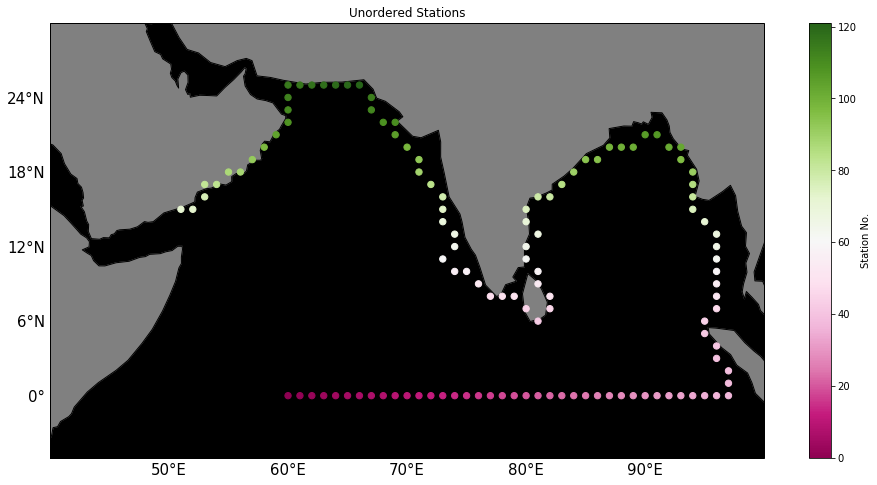

In [33]:
# ------------------------------------------------------------#
# block out a few places that you don't want to include
# ------------------------------------------------------------#

mask = TCD_binned_ave
xx,yy = np.meshgrid(lonbins,latbins)

# set Gulfs to Nans
mask = np.where(~((yy>22) & (xx<60)),mask,np.nan)
mask = np.where(~((yy>10) & (xx<51)),mask,np.nan)

# AS inlets
mask = np.where(~((yy>21.5) & (yy<22) & (xx>72) & (xx<73)),mask,np.nan)
mask = np.where(~((yy>22.25) & (yy<22) & (xx>69) & (xx<70.5)),mask,np.nan)
mask = np.where(~((yy>23.25) & (yy<22) & (xx>69) & (xx<70)),mask,np.nan)

# # sri lanka are
# mask = np.where(~((yy>8) & (yy<10.5) & (xx>78) & (xx<80.5)),mask,np.nan)

# # Sumatra area
# mask = np.where(~((yy>4.5) & (yy<5.5) & (xx>95.5) & (xx<99)),mask,np.nan)
# mask = np.where(~((yy>3) & (yy<5.5) & (xx>98) & (xx<101)),mask,np.nan)
mask = np.where(~((yy>7) & (yy<20) & (xx>96) & (xx<101)),mask,np.nan)
mask = np.where(~((yy>-2) & (yy<6.5) & (xx>97) & (xx<101)),mask,np.nan)

# # random points 

# mask = np.where(~((yy>12) & (yy<14) & (xx>91) & (xx<95)),mask,np.nan)
# mask = np.where(~((yy>21.5) & (yy<22) & (xx>72) & (xx<73)),mask,np.nan)
# mask = np.where(~((yy>6) & (yy<9) & (xx>98) & (xx<100)),mask,np.nan)

# equator
mask = np.where(~(yy<0),mask,np.nan)
# ------------------------------------------------------------#
# locate points along the BoB and AS
# ------------------------------------------------------------#

sta_latinds_unord, sta_loninds_unord = find_coast(np.array(mask))

# ------------------------------------------------------------#
# Remove Manually some other points
# ------------------------------------------------------------#

sta_latinds_unord = sta_latinds_unord[17:]
sta_loninds_unord = sta_loninds_unord[17:]

# AS
lons_from_sta = np.array(ds_CD.lonbins[sta_loninds_unord])
lats_from_sta = np.array(ds_CD.latbins[sta_latinds_unord])

ind = ~((lons_from_sta <52) & (lats_from_sta < 15))
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

#BoB
lons_from_sta = np.array(ds_CD.lonbins[sta_loninds_unord])
lats_from_sta = np.array(ds_CD.latbins[sta_latinds_unord])

ind = ~((lons_from_sta >91) & (lons_from_sta < 95) & (lats_from_sta >11) & (lats_from_sta < 15))
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#

bounds = [40,100,-5,30]

cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)
# cf = ax.contourf(lon, lat,sla_mon_anom[0,:,:],levels = levels,cmap=plt.cm.PuOr_r, extend="both")
plt.scatter(ds_CD.lonbins[sta_loninds_unord],ds_CD.latbins[sta_latinds_unord],
            s = 160,c=np.arange(len(sta_latinds_unord)),marker = '.',cmap =plt.cm.PiYG)
plt.colorbar(label = 'Station No.')
plt.title('Unordered Stations')

No Next Station Found. Returning Previous Stations Only.
(16, 35) [(62, 20)]


Text(0.5, 1.0, 'Stations')

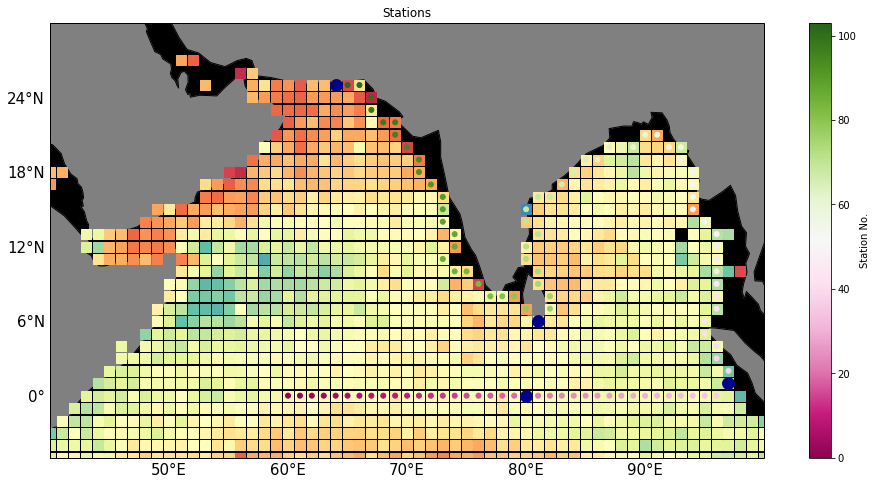

In [34]:
# ------------------------------------------------------------#
# put in the right order
# ------------------------------------------------------------#


def order_coast(loninds,latinds,sta_zero):
    # find based on radius
    zipped_lists = zip(loninds, latinds)
    sorted_pairs = sorted(zipped_lists, reverse=True)

    # sort by lon
    tuples = zip(*sorted_pairs)
    lon_list,lat_list  = [ list(tuple) for tuple in  tuples]

    pos = []
    curr_sta = []
    rem_sta = sorted_pairs
    for i in range(len(lon_list)):
#         print(i)
        if i == 0:
            curr_sta.append(sta_zero)
            rem_sta.remove(sta_zero) 
            prev_sta = sta_zero
        else:
            prev_sta = curr_sta[i-1]

        start_len = len(curr_sta)
        for j,(lo, la) in enumerate(rem_sta):
            
            next_sta = (rem_sta[j])
            
            diff = tuple(map(lambda l, k: l - k, curr_sta[i], next_sta))
            
            # check uplr first
            if(next_sta != prev_sta) & (all(np.abs(diff) == [0,1])) | (all(np.abs(diff) == [1,0])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                break

            # then check diagonals
            elif (next_sta != prev_sta) & (all(np.abs(diff) == [1,1])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                break
                
        if len(curr_sta) == start_len:
            print('No Next Station Found. Returning Previous Stations Only.')
            print(curr_sta[i],rem_sta)
            break
        
    sta_lonind, sta_latind  = map(np.array, zip(*curr_sta))
    
    return sta_lonind, sta_latind

#initial station
sta_zero = (sta_loninds_unord[0],sta_latinds_unord[0]) # 98.625, 10.375

#calculate
sta_loninds, sta_latinds =order_coast(sta_loninds_unord,sta_latinds_unord,sta_zero)

sta_latinds = sta_latinds[:-17]
sta_loninds = sta_loninds[:-17]

# ------------------------------------------------------------#
# identify first stations for EQ, BOB, and AS
# ------------------------------------------------------------#

# EQ = 0
JA = 20
sBoB = 37
# mBoB = 65
SL = 78
mAS = 103
# eAS = 90
loc_list = [JA,sBoB,SL,mAS]

# ------------------------------------------------------------#
# plot
# ------------------------------------------------------------#
bounds = [40,100,-5,30]
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)
xx,yy = np.meshgrid(ds_CD.lonbins,ds_CD.latbins)
xx = xx.flatten()
yy = yy.flatten()
p2 = plt.scatter(xx,yy,c = TCD_binned_ave.flatten(),marker='s',
                      s = 100,cmap=plt.cm.Spectral,vmin=20,vmax=160,transform=ccrs.PlateCarree())
p =plt.scatter(ds_CD.lonbins[sta_loninds],ds_CD.latbins[sta_latinds],
            s = 100,c=np.arange(len(sta_latinds)),marker = '.',cmap =plt.cm.PiYG)
plt.scatter(ds_CD.lonbins[sta_loninds[loc_list]],ds_CD.latbins[sta_latinds[loc_list]],
            s = 560,c='darkblue',marker = '.')
plt.colorbar(p,label = 'Station No.')

plt.title('Stations')

# plt.savefig('../figures/stations-SLA-along-coast.png', dpi=300, bbox_inches='tight')

# Find IOD / Not Seasons

In [35]:
month = ds_CD.time.dt.month
month = np.array(month)
IODseason = np.full(month.shape,1)

# find IOD season 08-01 and non IOD season 02-07
IODseason = np.where((month >= 8) & (month <= 12),IODseason,0)

# add to dataset
ds_CD['IODseason'] = xr.DataArray(IODseason,dims = ['time'],coords =[ds_CD.time])

# Group Into IOD Phases

In [36]:
# load DMI data
ds_DMI= xr.open_dataset('../data/DMI/dmi_processed.nc')
ds_DMI

posIODyears = list(np.array(ds_DMI.pos_IOD_years))
negIODyears = list(np.array(ds_DMI.neg_IOD_years))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years)) 

In [37]:
# binning for one variable ------------------------------------------------------------#
def latlonbin_season(invar,lat,lon,season,bounds,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            invar = np.array(invar),
            lat= np.array(lat),
            lon= np.array(lon),
            season = np.array(season)
        ))

    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    invar_BINNED = np.zeros((2,len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_BINNED[:] = np.nan

    invar_binned_ave = np.zeros((2,len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_binned_ave[:] = np.nan
    
    invar_bincounts = np.zeros((2,len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_bincounts[:] = np.nan
    
    #extract the data for each group
    for name,group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)
        
        #group a second time by IOD Season
        seas_grouped = group.groupby(['season'])
        
        for ss,seas_group in seas_grouped:
#             print(ss,np.array(seas_group.season))

            invar_BINNED[ss,i[0],j[0]] = np.array(seas_group.invar)

            invar_binned_ave[ss,i[0],j[0]] = np.nanmean(seas_group.invar)   

            invar_bincounts[ss,i[0],j[0]] = len(seas_group.invar[np.isfinite(seas_group.invar)]) 


    return (np.array(invar_binned_ave,dtype = float),invar_BINNED,
            np.array(invar_bincounts,dtype = float),latbins,lonbins)

## Seasonal

In [45]:
# average over the positive IOD years -------------------------------------------# 
dataTCD = []
lat = []
lon = []
time = []
seas = []

for ii,year in enumerate(posIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    dataTCD.extend(np.array(ds_CD.TCD_AWG.sel(time=time_slice)))
    lat.extend(np.array(ds_CD.lat.sel(time=time_slice)))
    lon.extend(np.array(ds_CD.lon.sel(time=time_slice)))
    time.extend(np.array(ds_CD.time.sel(time=time_slice)))
    seas.extend(np.array(ds_CD.IODseason.sel(time=time_slice)))


bounds = [35,120,-20,30]
    
# bin for each month
posIOD_TCD_bin_ave,posIOD_TCD_bin_vals,posIOD_TCD_bncts,latbins,lonbins = latlonbin_season(dataTCD,
                                                                                           lat,lon,seas,
                                                                                           bounds,1)

# average over the positive IOD years -------------------------------------------# 
dataTCD = []
lat = []
lon = []
time = []
seas = []

for ii,year in enumerate(negIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    dataTCD.extend(np.array(ds_CD.TCD_AWG.sel(time=time_slice)))
    lat.extend(np.array(ds_CD.lat.sel(time=time_slice)))
    lon.extend(np.array(ds_CD.lon.sel(time=time_slice)))
    time.extend(np.array(ds_CD.time.sel(time=time_slice)))
    seas.extend(np.array(ds_CD.IODseason.sel(time=time_slice)))


bounds = [35,120,-20,30]
    
# bin for each month
negIOD_TCD_bin_ave,negIOD_TCD_bin_vals,negIOD_TCD_bncts,latbins,lonbins = latlonbin_season(dataTCD,lat,lon,
                                                                                           seas,bounds,1)


# average over the positive IOD years -------------------------------------------# 
dataTCD = []
lat = []
lon = []
time = []
seas = []

for ii,year in enumerate(neuIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    dataTCD.extend(np.array(ds_CD.TCD_AWG.sel(time=time_slice)))
    lat.extend(np.array(ds_CD.lat.sel(time=time_slice)))
    lon.extend(np.array(ds_CD.lon.sel(time=time_slice)))
    time.extend(np.array(ds_CD.time.sel(time=time_slice)))
    seas.extend(np.array(ds_CD.IODseason.sel(time=time_slice)))


bounds = [35,120,-20,30]
    
# bin for each month
neuIOD_TCD_bin_ave,neuIOD_TCD_bin_vals,neuIOD_TCD_bncts,latbins,lonbins = latlonbin_season(dataTCD,lat,lon,seas,
                                                                                           bounds,1)


/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice


In [47]:
phase_list = [posIOD_TCD_bin_vals,negIOD_TCD_bin_vals,neuIOD_TCD_bin_vals]
# group into larger coastal blocks
phase_data = np.zeros([3], dtype=np.ndarray)
for pp,phase in enumerate(phase_list):
    data = np.zeros([2,sta_loninds.shape[0]], dtype=np.ndarray)
    block_data = np.zeros([2,len(loc_list)], dtype=np.ndarray)
    for ss in range(2):
        for jj in range(sta_loninds.shape[0]):
            data[ss,jj] = np.array(phase[ss,sta_latinds[jj],sta_loninds[jj]])

        for ll in range(len(loc_list)-1):
            for mm in range(loc_list[ll+1]-loc_list[ll]):
                if mm == 0:
                    tup  = data[ss,loc_list[mm]]
                else:
                    tup = np.hstack((tup,data[ss,loc_list[ll]+mm]))

            block_data[ss,ll] = tup
    phase_data[pp] = block_data

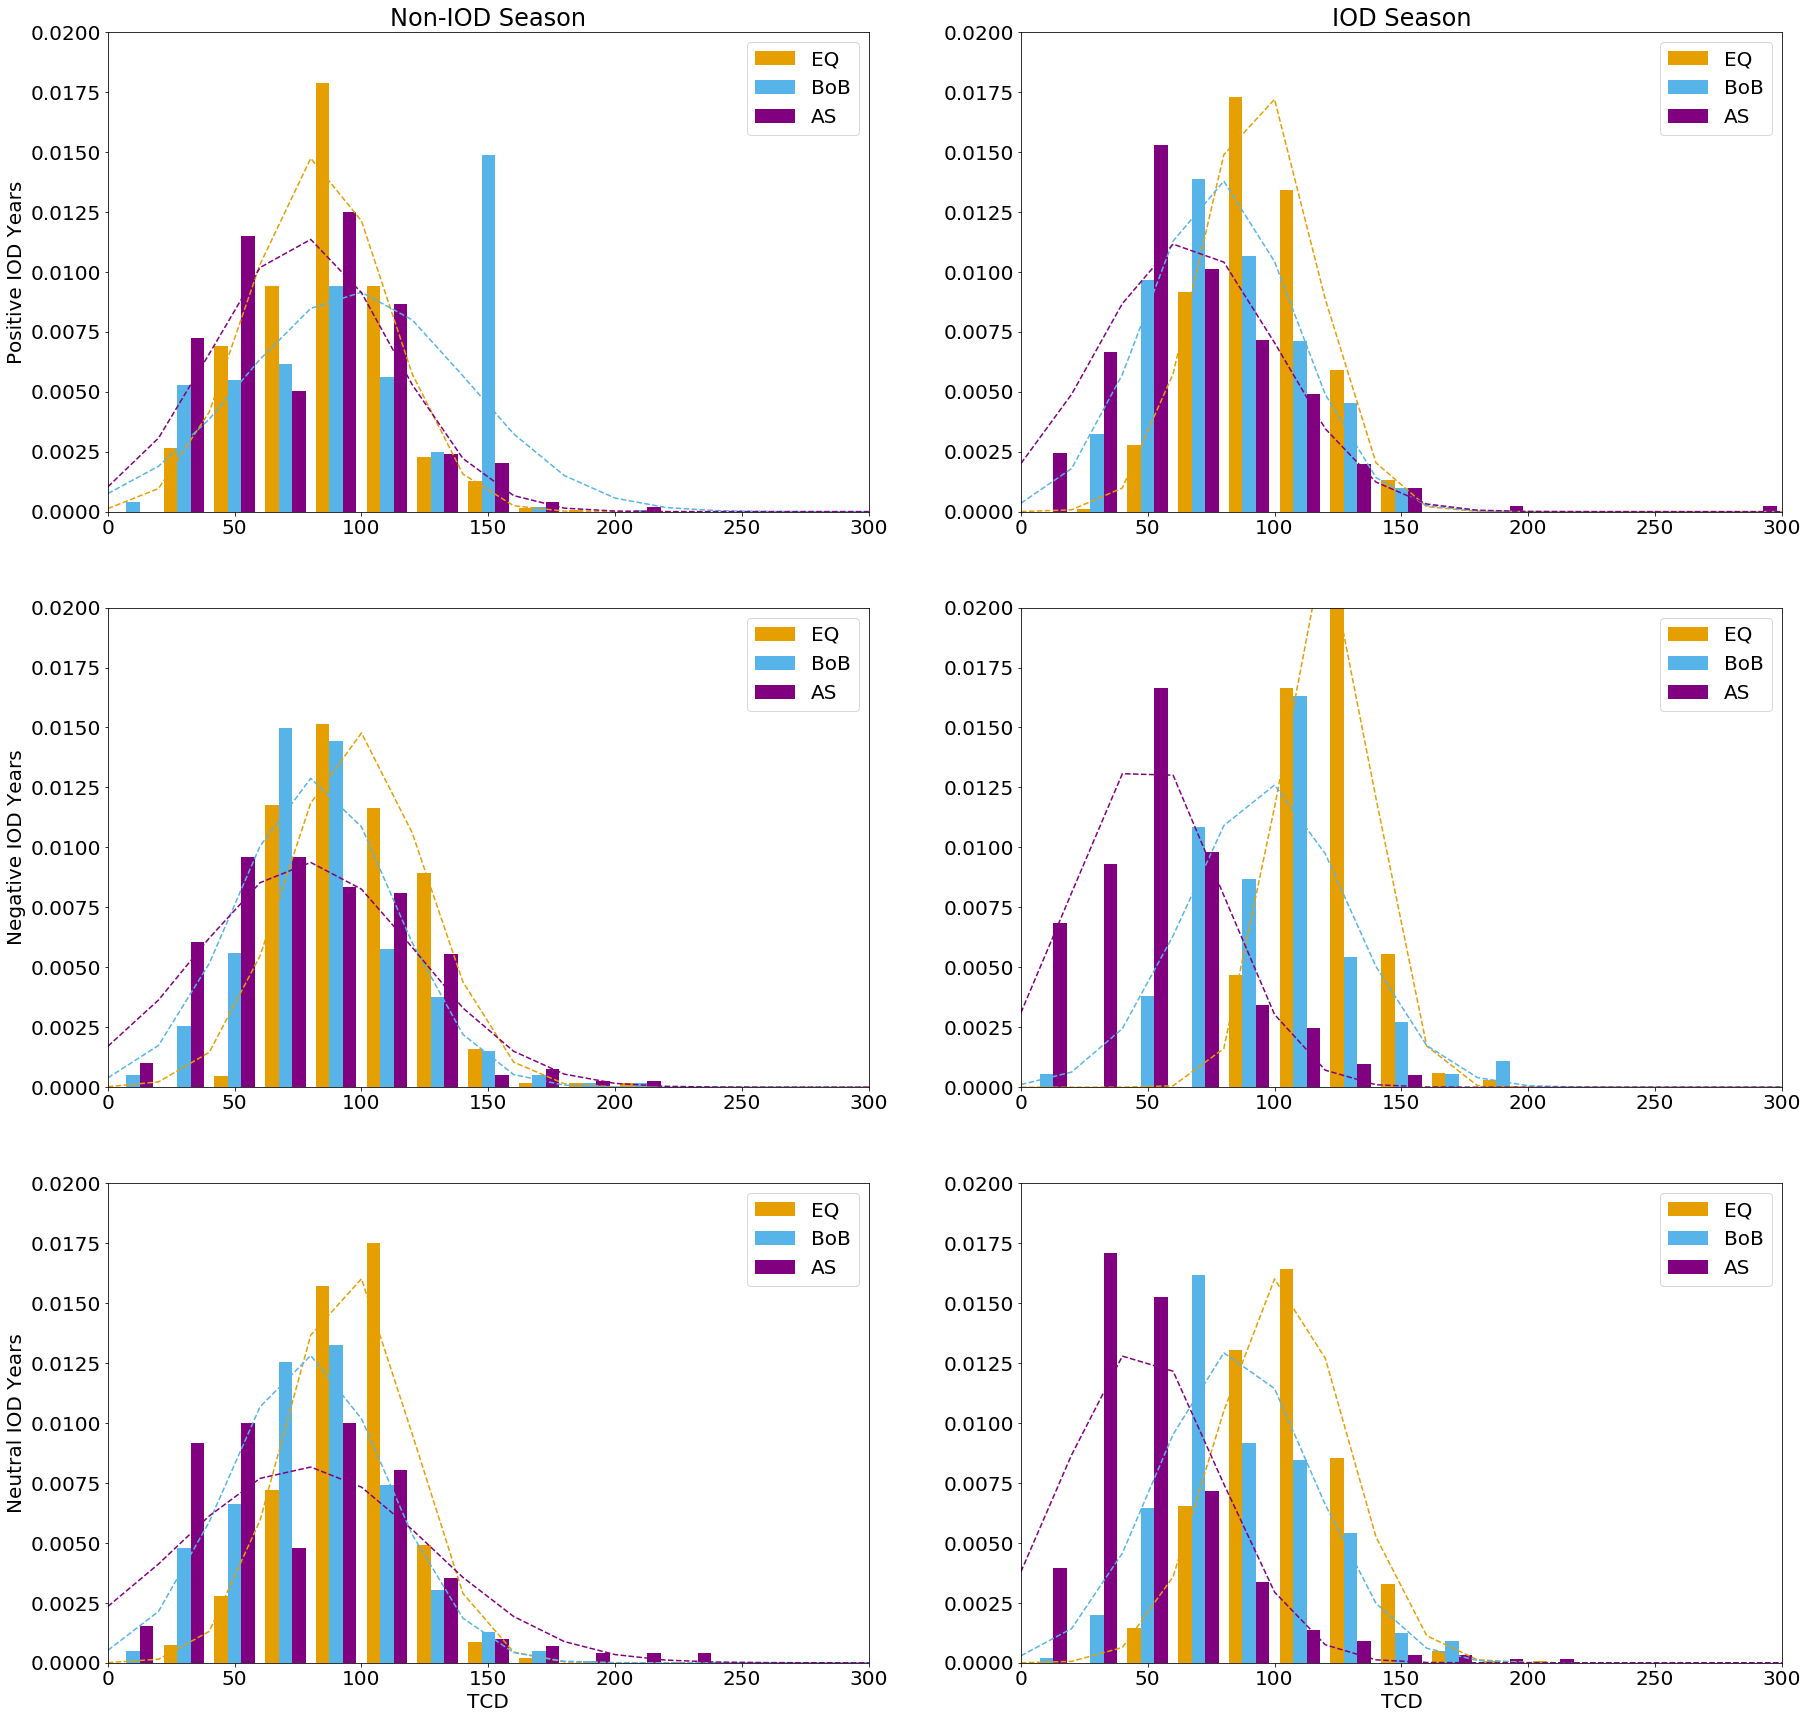

In [49]:
cnt = 1
seas_title = ['Non-IOD Season', 'IOD Season']
phase_title = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
fig = plt.figure(figsize=(30, 30))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(0,300,16)
for pp in range(3):
    for ss in range(2):
        # Make a separate list for each airline
        x1 = list(phase_data[pp][ss,0])
        x2 = list(phase_data[pp][ss,1])
        x3 = list(phase_data[pp][ss,2])

        # Assign colors for each airline and the names
        colors = ['#E69F00', '#56B4E9', 'purple']
        names = ['EQ', 'BoB', 'AS']

        # Make the histogram using a list of lists
        # Normalize the flights and assign colors and names
        ax = fig.add_subplot(3,2,cnt)
        n, bins, patches = plt.hist([x1, x2, x3],bins = binedges,
                 density = True,
                 color = colors, label=names)
        for ii,x in enumerate([x1,x2,x3]):
            mu = np.nanmean(x)
            sigma = np.nanstd(x)
            y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
             np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
            plt.plot(bins, y, '--',c = colors[ii])

        # Plot formatting
        plt.legend()
        if (cnt == 5) | (cnt ==6):
            plt.xlabel('TCD')
        if ss == 0:
            plt.ylabel(phase_title[pp])
        plt.ylim(0,0.02)
        plt.xlim(0,300)
        if (cnt == 1) | (cnt ==2):
            plt.title(seas_title[ss])
        cnt = cnt+1

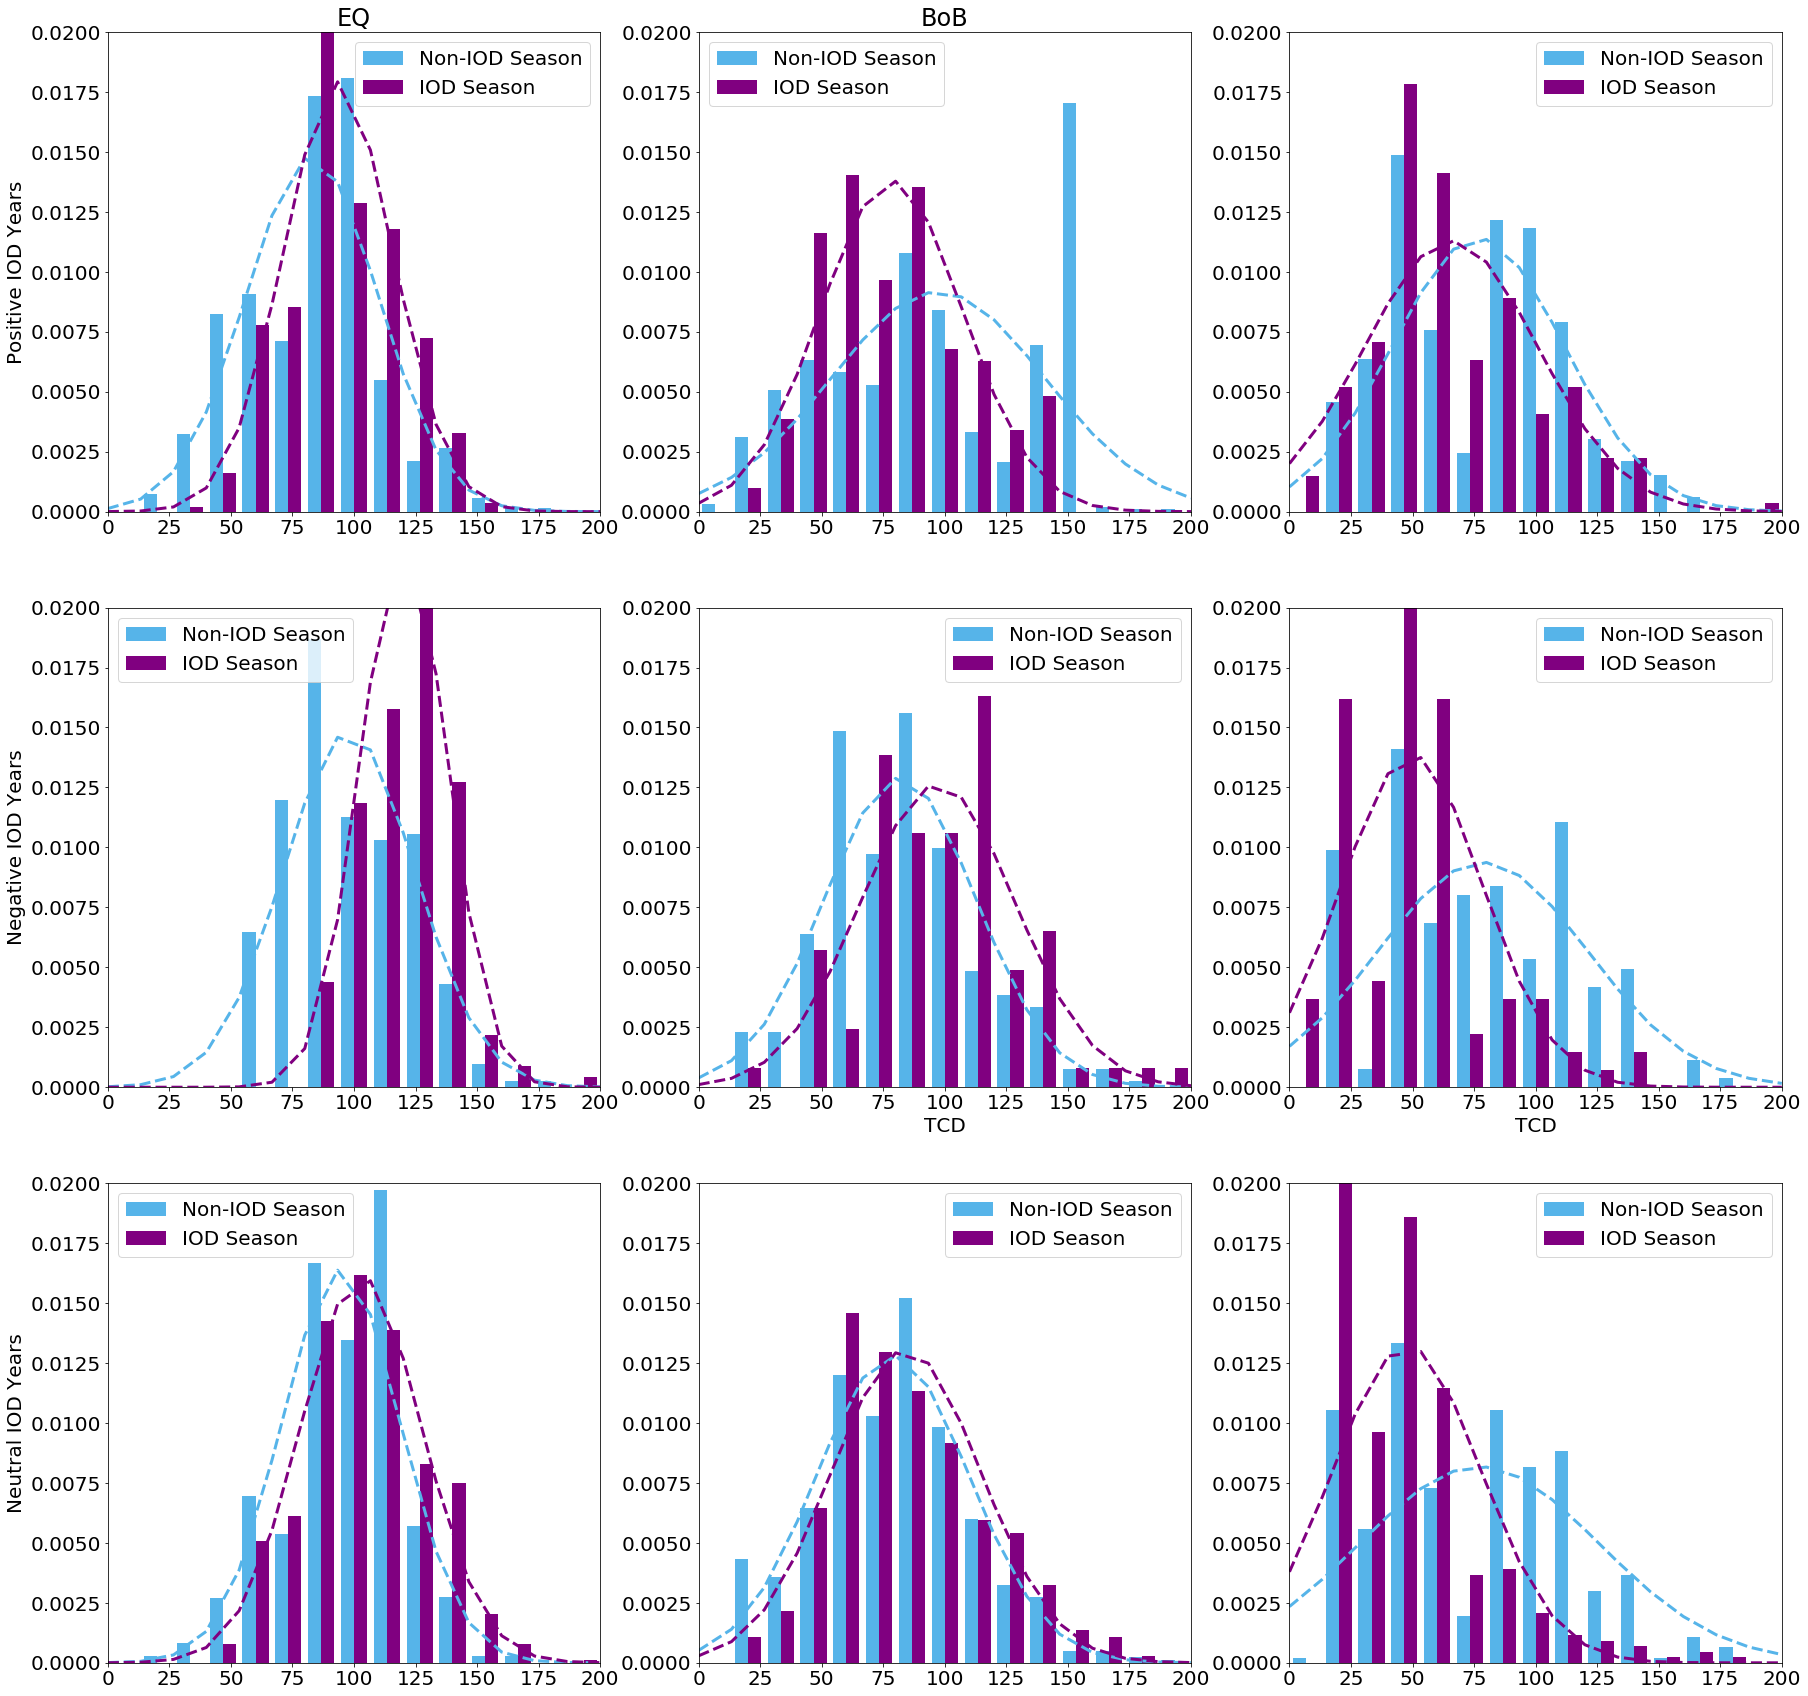

In [50]:
cnt = 1
phase_title = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
seas_title = ['EQ', 'BoB', 'AS']
fig = plt.figure(figsize=(30, 30))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(0,200,16)
for pp in range(3):

    for loc in range(3):
        # Make a separate list for each airline
        x1 = list(phase_data[pp][0,loc])
        x2 = list(phase_data[pp][1,loc])

        # Assign colors for each airline and the names
        colors = ['#56B4E9', 'purple']
        names = ['Non-IOD Season','IOD Season']

        # Make the histogram using a list of lists
        # Normalize the flights and assign colors and names
        ax = fig.add_subplot(3,3,cnt)
        n, bins, patches = plt.hist([x1, x2],bins = binedges,
                 density = True,
                 color = colors, label=names)
        for ii,x in enumerate([x1,x2]):
            mu = np.nanmean(x)
            sigma = np.nanstd(x)
            y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
             np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
            plt.plot(bins, y, '--',c = colors[ii],linewidth = 3)

        # Plot formatting
        plt.legend()
        if (cnt == 5) | (cnt ==6):
            plt.xlabel('TCD')
        if loc == 0:
            plt.ylabel(phase_title[pp])
        plt.ylim(0,0.02)
        plt.xlim(0,200)
        if (cnt == 1) | (cnt ==2):
            plt.title(seas_title[loc])
        cnt = cnt + 1

## Interannual

In [52]:
# average over the positive IOD years -------------------------------------------# 
dataTCD = []
lat = []
lon = []
time = []
seas = []

for ii,year in enumerate(posIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    dataTCD.extend(np.array(ds_CD.TCD_anom.sel(time=time_slice)))
    lat.extend(np.array(ds_CD.lat.sel(time=time_slice)))
    lon.extend(np.array(ds_CD.lon.sel(time=time_slice)))
    time.extend(np.array(ds_CD.time.sel(time=time_slice)))
    seas.extend(np.array(ds_CD.IODseason.sel(time=time_slice)))


bounds = [35,120,-20,30]
    
# bin for each month
posIOD_TCD_anom_bin_ave,posIOD_TCD_anom_bin_vals,posIOD_TCD_anom_bncts,latbins,lonbins = latlonbin_season(dataTCD,
                                                                                                          lat,lon,
                                                                                                          seas,
                                                                                                          bounds,1)

# average over the positive IOD years -------------------------------------------# 
dataTCD = []
lat = []
lon = []
time = []
seas = []

for ii,year in enumerate(negIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    dataTCD.extend(np.array(ds_CD.TCD_anom.sel(time=time_slice)))
    lat.extend(np.array(ds_CD.lat.sel(time=time_slice)))
    lon.extend(np.array(ds_CD.lon.sel(time=time_slice)))
    time.extend(np.array(ds_CD.time.sel(time=time_slice)))
    seas.extend(np.array(ds_CD.IODseason.sel(time=time_slice)))


bounds = [35,120,-20,30]
    
# bin for each month
negIOD_TCD_anom_bin_ave,negIOD_TCD_anom_bin_vals,negIOD_TCD_anom_bncts,latbins,lonbins = latlonbin_season(dataTCD,
                                                                                                          lat,lon,
                                                                                                          seas,
                                                                                                          bounds,1)


# average over the positive IOD years -------------------------------------------# 
dataTCD = []
lat = []
lon = []
time = []
seas = []

for ii,year in enumerate(neuIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    dataTCD.extend(np.array(ds_CD.TCD_anom.sel(time=time_slice)))
    lat.extend(np.array(ds_CD.lat.sel(time=time_slice)))
    lon.extend(np.array(ds_CD.lon.sel(time=time_slice)))
    time.extend(np.array(ds_CD.time.sel(time=time_slice)))
    seas.extend(np.array(ds_CD.IODseason.sel(time=time_slice)))


bounds = [35,120,-20,30]
    
# bin for each month
neuIOD_TCD_anom_bin_ave,neuIOD_TCD_anom_bin_vals,neuIOD_anom_TCD_bncts,latbins,lonbins = latlonbin_season(dataTCD,
                                                                                                          lat,lon,
                                                                                                          seas,
                                                                                                          bounds,1)




/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice


In [53]:
phase_list = [posIOD_TCD_anom_bin_vals,negIOD_TCD_anom_bin_vals,neuIOD_TCD_anom_bin_vals]
# group into larger coastal blocks
phase_data = np.zeros([3], dtype=np.ndarray)
for pp,phase in enumerate(phase_list):
    data = np.zeros([2,sta_loninds.shape[0]], dtype=np.ndarray)
    block_data = np.zeros([2,len(loc_list)], dtype=np.ndarray)
    for ss in range(2):
        for jj in range(sta_loninds.shape[0]):
            data[ss,jj] = np.array(phase[ss,sta_latinds[jj],sta_loninds[jj]])

        for ll in range(len(loc_list)-1):
            for mm in range(loc_list[ll+1]-loc_list[ll]):
                if mm == 0:
                    tup  = data[ss,loc_list[mm]]
                else:
                    tup = np.hstack((tup,data[ss,loc_list[ll]+mm]))

            block_data[ss,ll] = tup
    phase_data[pp] = block_data

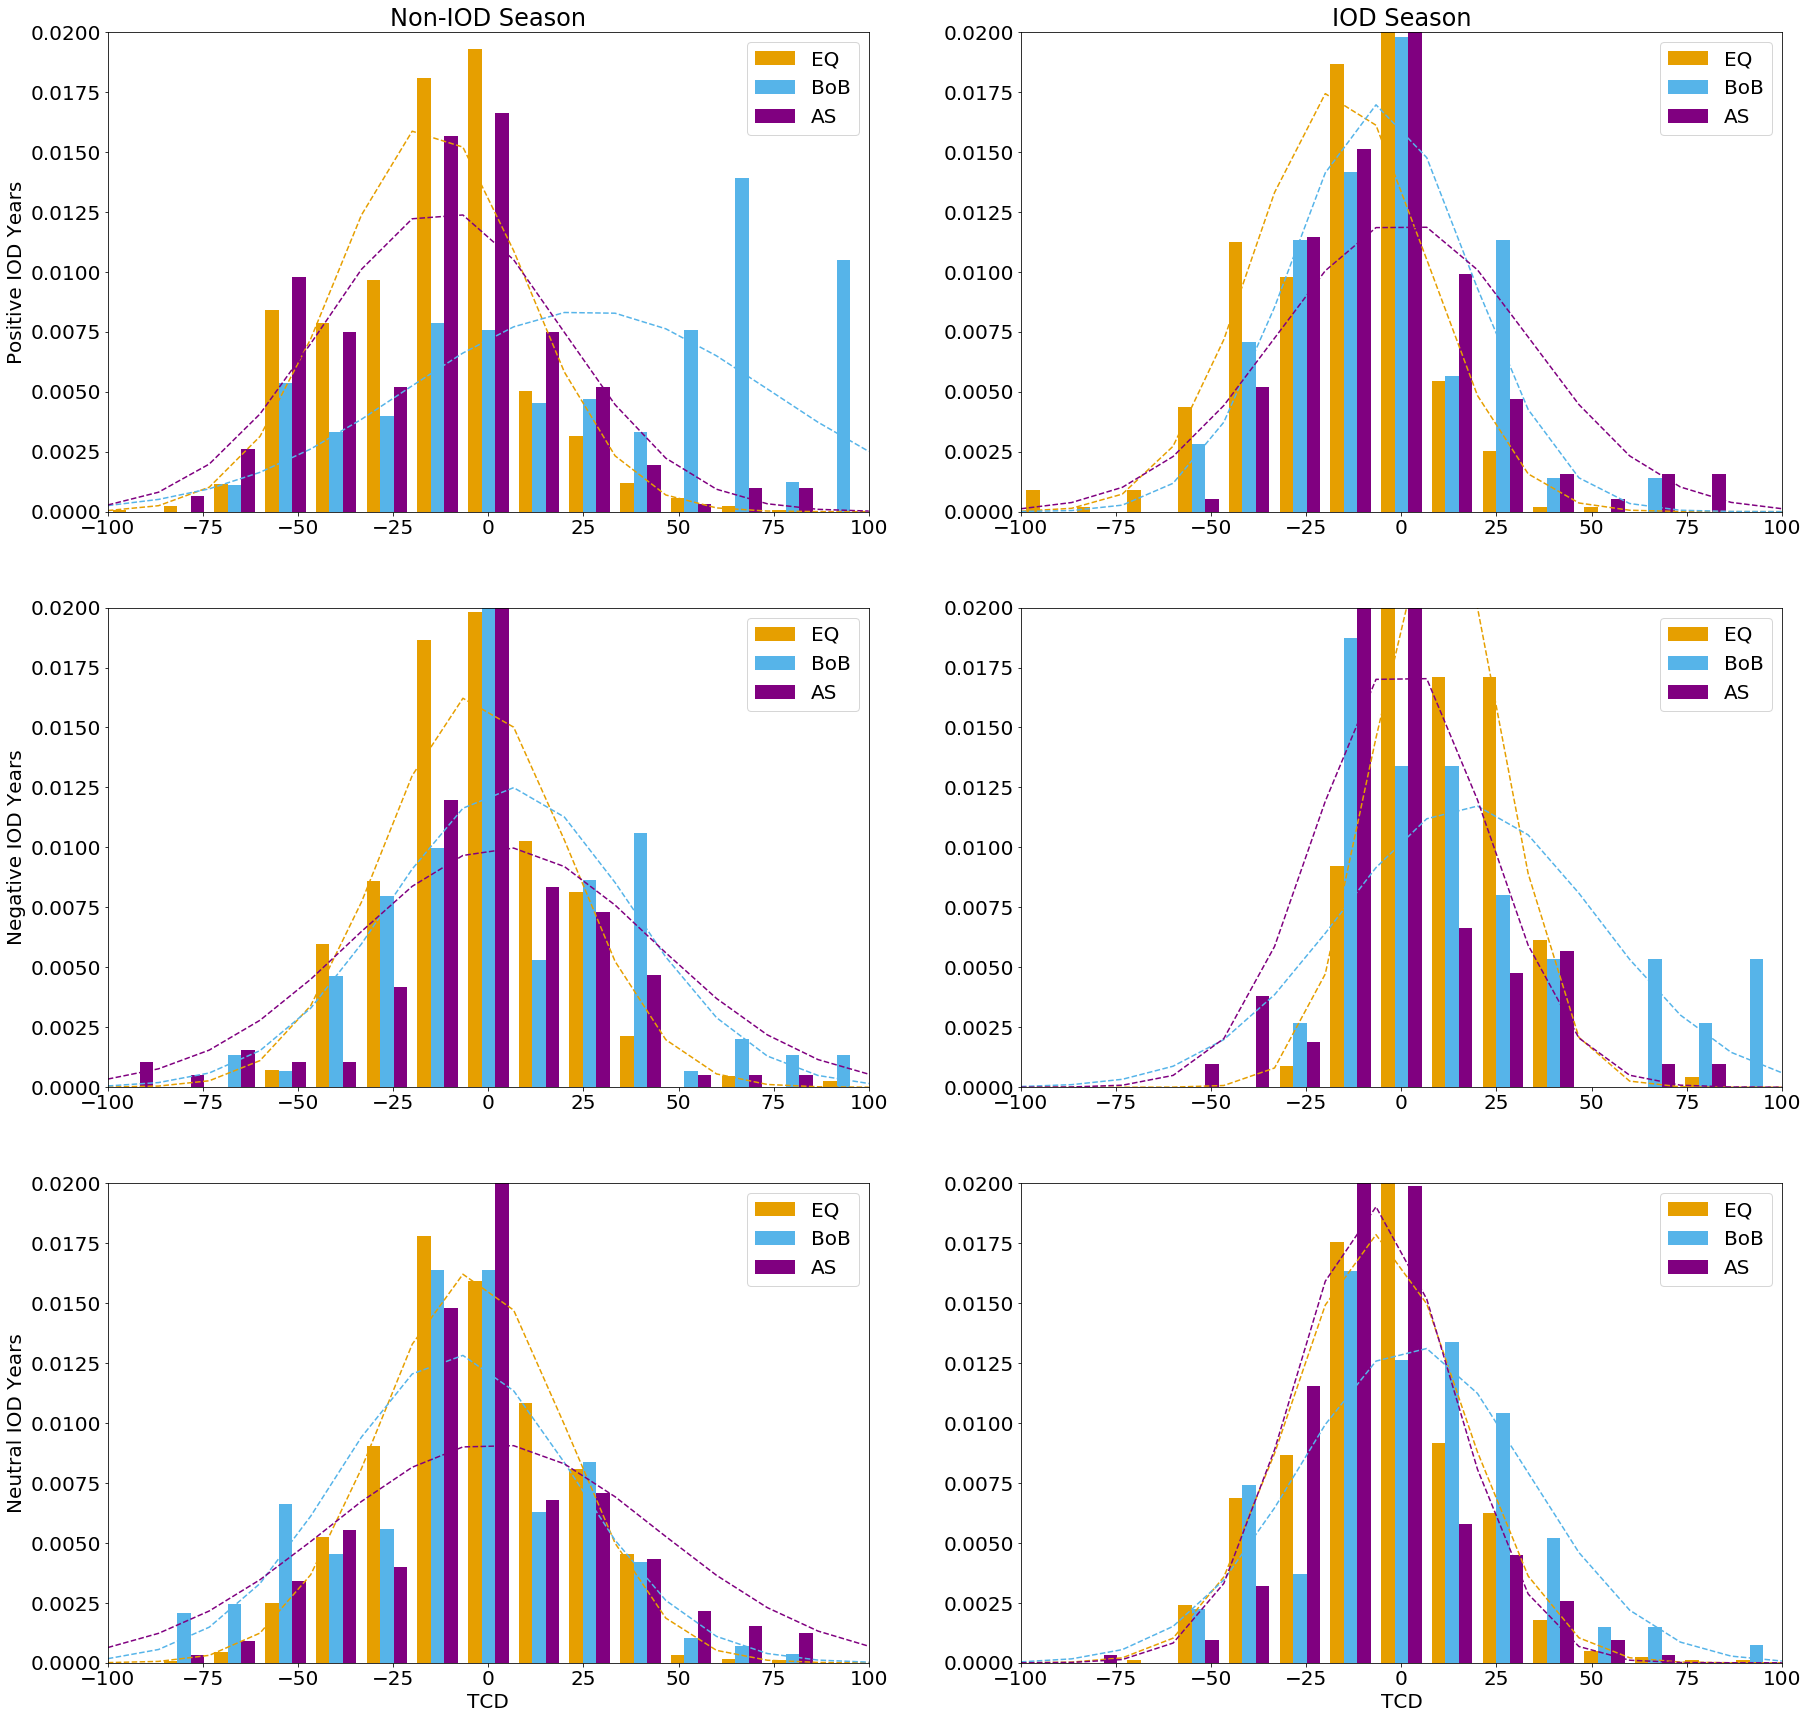

In [54]:
cnt = 1
seas_title = ['Non-IOD Season', 'IOD Season']
phase_title = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
fig = plt.figure(figsize=(30, 30))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(-100,100,16)
for pp in range(3):
    for ss in range(2):
        # Make a separate list for each airline
        x1 = list(phase_data[pp][ss,0])
        x2 = list(phase_data[pp][ss,1])
        x3 = list(phase_data[pp][ss,2])

        # Assign colors for each airline and the names
        colors = ['#E69F00', '#56B4E9', 'purple']
        names = ['EQ', 'BoB', 'AS']

        # Make the histogram using a list of lists
        # Normalize the flights and assign colors and names
        ax = fig.add_subplot(3,2,cnt)
        n, bins, patches = plt.hist([x1, x2, x3],bins = binedges,
                 density = True,
                 color = colors, label=names)
        for ii,x in enumerate([x1,x2,x3]):
            mu = np.nanmean(x)
            sigma = np.nanstd(x)
            y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
             np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
            plt.plot(bins, y, '--',c = colors[ii])

        # Plot formatting
        plt.legend()
        if (cnt == 5) | (cnt ==6):
            plt.xlabel('TCD')
        if ss == 0:
            plt.ylabel(phase_title[pp])
        plt.ylim(0,0.02)
        plt.xlim(-100,100)
        if (cnt == 1) | (cnt ==2):
            plt.title(seas_title[ss])
        cnt = cnt+1

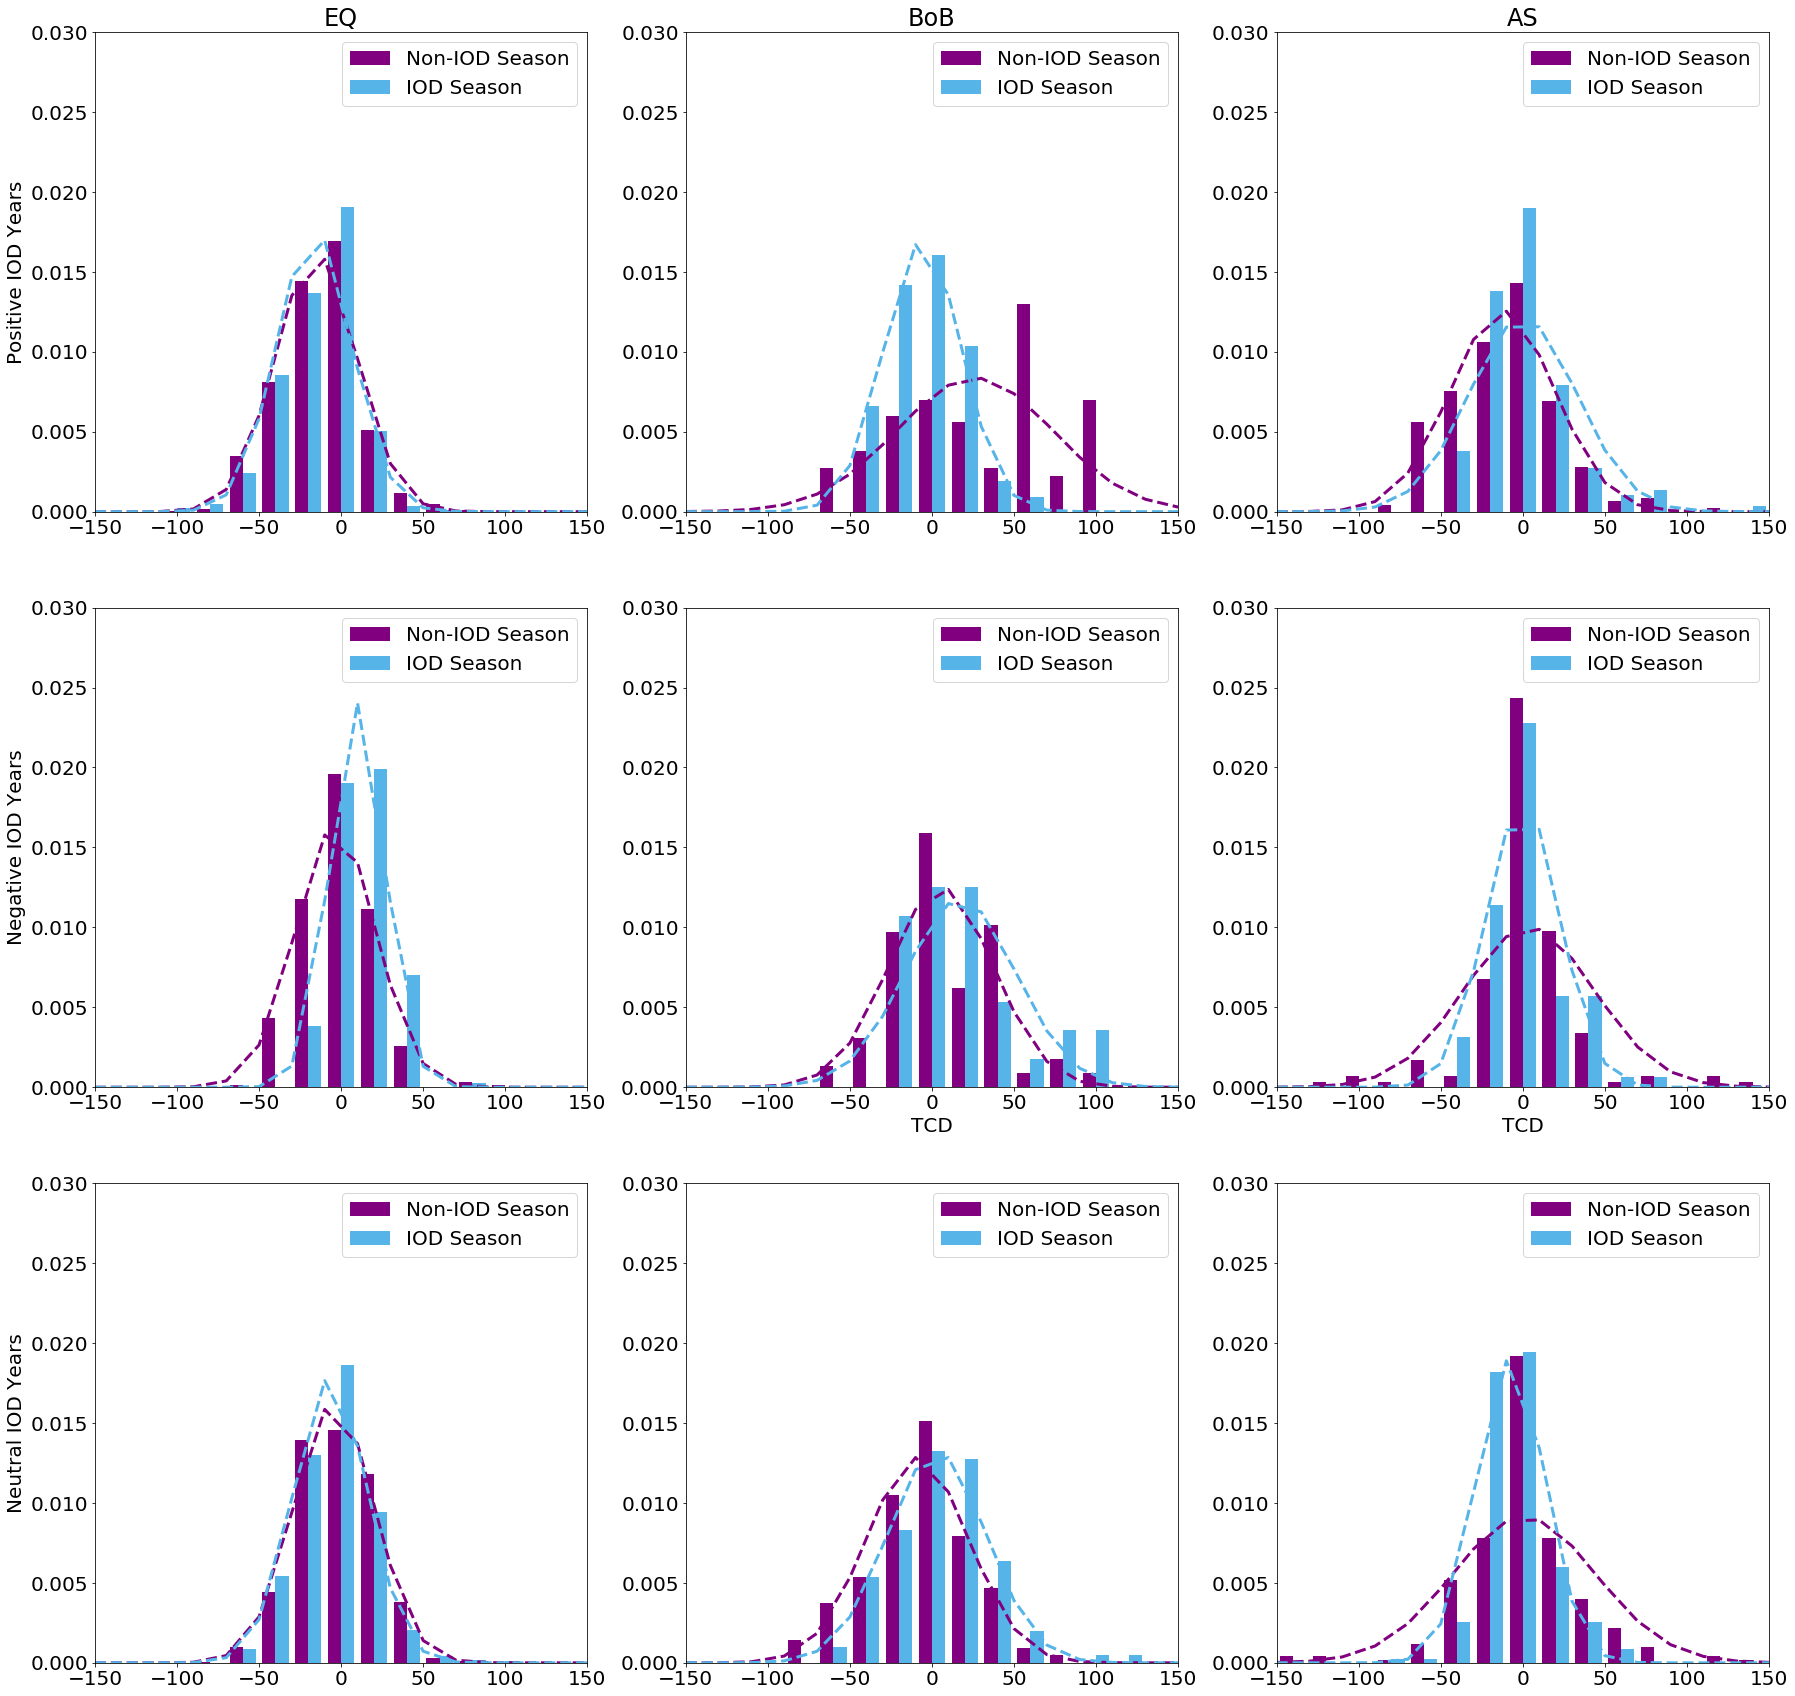

In [55]:
cnt = 1
phase_title = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
seas_title = ['EQ', 'BoB', 'AS']
fig = plt.figure(figsize=(30, 30))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(-150,150,16)
for pp in range(3):

    for loc in range(3):
        # Make a separate list for each airline
        x1 = list(phase_data[pp][0,loc])
        x2 = list(phase_data[pp][1,loc])

        # Assign colors for each airline and the names
        colors = [ 'purple','#56B4E9']
        names = ['Non-IOD Season','IOD Season']

        # Make the histogram using a list of lists
        # Normalize the flights and assign colors and names
        ax = fig.add_subplot(3,3,cnt)
        n, bins, patches = plt.hist([x1, x2],bins = binedges,
                 density = True,
                 color = colors, label=names)
        for ii,x in enumerate([x1,x2]):
            mu = np.nanmean(x)
            sigma = np.nanstd(x)
            y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
             np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
            plt.plot(bins, y, '--',c = colors[ii],linewidth = 3)

        # Plot formatting
        plt.legend()
        if (cnt == 5) | (cnt ==6):
            plt.xlabel('TCD')
        if loc == 0:
            plt.ylabel(phase_title[pp])
        plt.ylim(0,0.03)
        plt.xlim(-150,150)
        if (cnt == 1) | (cnt ==2) | (cnt == 3):
            plt.title(seas_title[loc])
        cnt = cnt + 1